In [ ]:
import numpy as np
import matplotlib.pyplot as plt 
from apdist.torch import TorchAmplitudePhaseDistance as torch_apdist 
import torch 
from apdist.torch import plot_warping as plot_warping_torch
from apdist.distances import AmplitudePhaseDistance as numpy_apdist 
from apdist.utils import plot_warping 
from apdist.geometry import SquareRootSlopeFramework as SRSF

### Load data
We will be using experimentally collected UV-Vis spectroscopy data of gold nanoparticles of roughly spherical and cylindrical shape

In [6]:
data = np.load('./data/02/uvvis.npz')
wav = data['wav']
wav_scaled = (wav-min(wav))/(max(wav)-min(wav))
sphere = data['sphere']
cylinder = data['cylinder'] 

we can now visualize two spectra we are interested on the 2d plot with wavelength on the x-axis and intensity on the y-axis

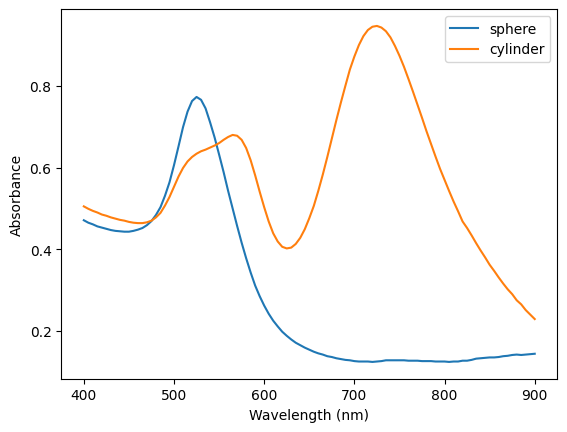

In [5]:
fig, ax = plt.subplots()

ax.plot(wav, sphere, label = 'sphere')
ax.plot(wav, cylinder, label = 'cylinder')
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Absorbance')
ax.legend()
plt.show()

### Case 1

we can now compute the distance between the two spectra by warping one function to closely match the shape of the other. We are going to compute warping with first sphere spectra as a reference and then the cylinder spectra to showcase that the warping is not permutation invariance so are the distances.

Amplitude : 0.8419, Phase : 0.6475, Total : 1.4893


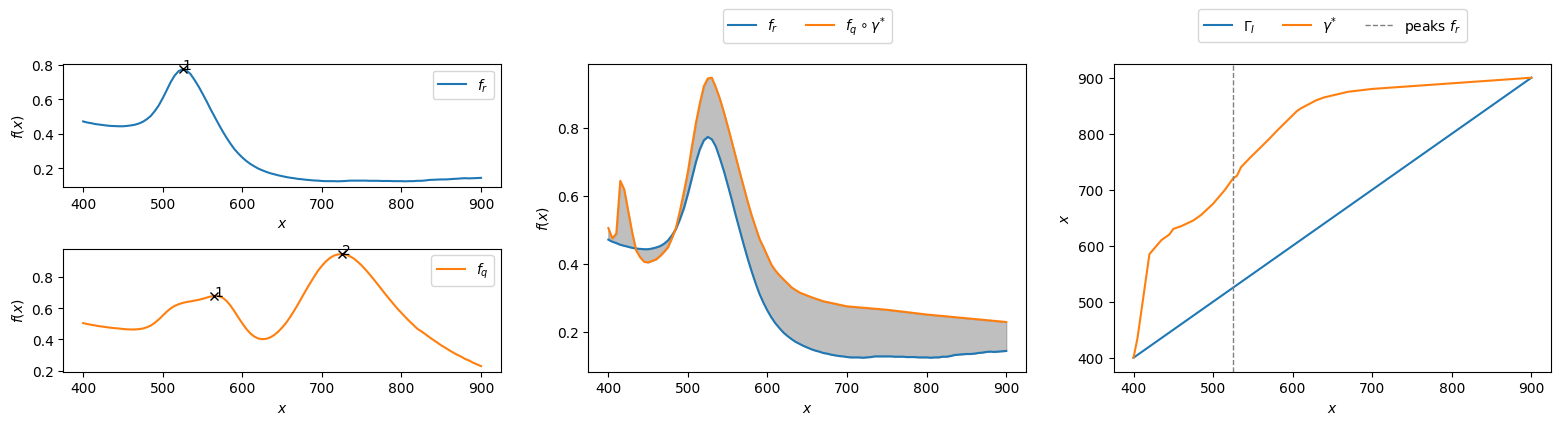

In [7]:
optim_kwargs = {"optim":"DP", "grid_dim":10}
a, p = numpy_apdist(wav_scaled, sphere, cylinder, **optim_kwargs)
print("Amplitude : %2.4f, Phase : %2.4f, Total : %2.4f"%(a, p, a+p))

srsf = SRSF(wav_scaled)
q_ref = srsf.to_srsf(sphere)
q_good = srsf.to_srsf(cylinder)
gamma_good = srsf.get_gamma(q_ref, q_good, **optim_kwargs)
f_query_gamma = srsf.warp_f_gamma(cylinder, gamma_good)
plot_warping(wav, sphere, cylinder, f_query_gamma, gamma_good)
plt.show()

We can observe that warping function tried to align the two large intensity peaks acros the two curve but still retained the first peak from the cylinder nanoparticle spectrum after the warping. This resulted in a significant amplitude and phase distance between the two curves.

Now, let's compare how the warping would change when we switch the reference and query curves.

### Case 2

Amplitude : 0.7821, Phase : 0.6499, Total : 1.4320


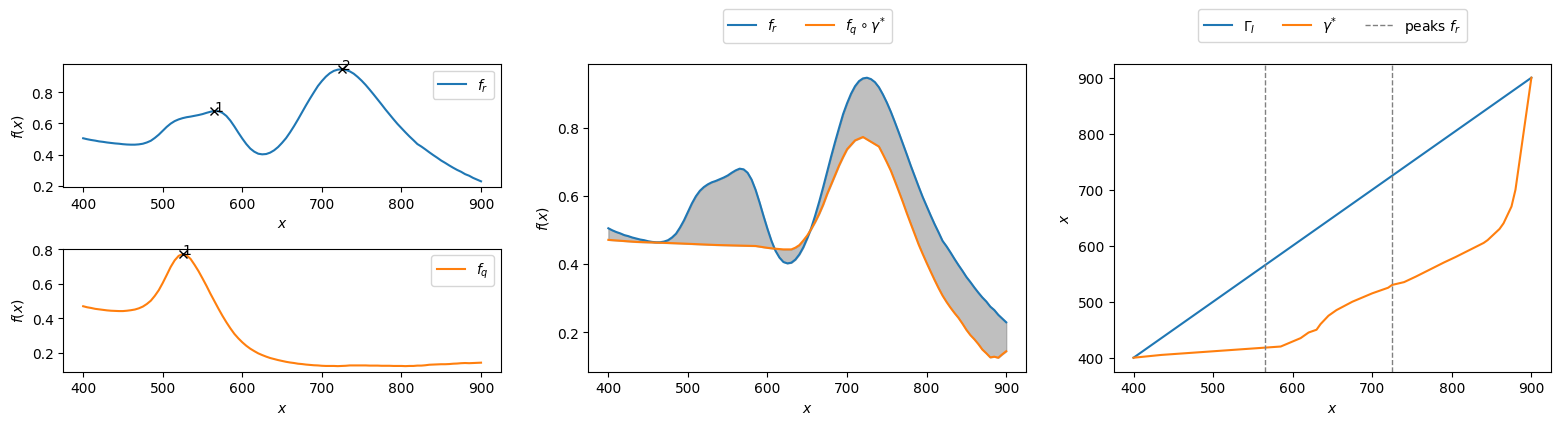

In [8]:
a, p = numpy_apdist(wav_scaled, cylinder, sphere, **optim_kwargs)
print("Amplitude : %2.4f, Phase : %2.4f, Total : %2.4f"%(a, p, a+p))

srsf = SRSF(wav_scaled)
q_ref = srsf.to_srsf(cylinder)
q_good = srsf.to_srsf(sphere)
gamma_good = srsf.get_gamma(q_ref, q_good, **optim_kwargs)
f_query_gamma = srsf.warp_f_gamma(sphere, gamma_good)
plot_warping(wav, cylinder, sphere, f_query_gamma, gamma_good)
plt.show()

Now note that warping function is distinctly different and the amplitude and phase components are also distinct between the two versions. This is because, when warping sphere spectrum with one peak to a cylinder spectrum with two peaks as done in the cell above, we are only interested in moving the primary peak in the sphere spectrum to match that of the cylinder spectrum at ~700 nm. On the flip side in case 1, we have to align two peaks from the cylinder spectrum to a single peaked sphere spectrum and doing so would require us to make the extra peak as sharp as possible so that it has the least intensity.

Note that, a better warping function in case 1 would be the one that completely flattens the extra peak and therefore incurs even more penalty in the phase distance. Let's see if our torch version can achieve such warping function.

### Case 1

Amplitude : 0.6191, Phase : 0.7291, Total : 1.348128


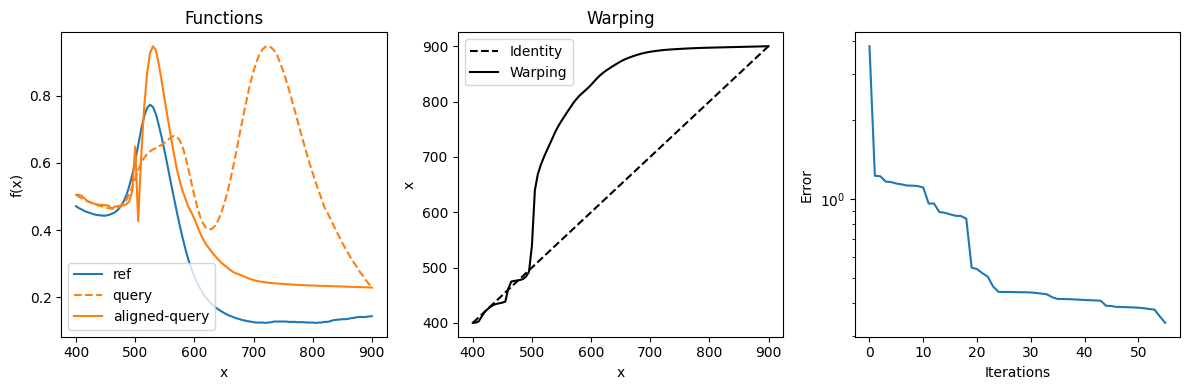

In [9]:
optim_kwargs = {"n_iters":100, 
                "n_basis":20, 
                "n_layers":20,
                "n_restarts":128,
                "domain_type":"linear",
                "basis_type":"palais",
                "lr":1e-1,
                "n_domain":wav.shape[0],
                "eps":1e-2,
                "verbose" : True
            }

amplitude, phase, case1 = torch_apdist(torch.from_numpy(wav_scaled),
                                       torch.from_numpy(sphere),
                                       torch.from_numpy(cylinder),
                                       **optim_kwargs
                                    )
print("Amplitude : %2.4f, Phase : %2.4f, Total : %2.4f"%(amplitude.item(), phase.item(), amplitude.item()+phase.item()))
plot_warping_torch(wav, sphere, cylinder, case1)


and it does indeed or at least very close. Making the peak very sharp means it almost incurs no penalty in the optimization score of the warping function computation so the gradient descent is tending prefer such solution. As expected, phase distance is larger than the discrete case discussed above. 

Now let's see if it adds an extra peak to a sphere spectrum to make it look much closer to the cylinder spectrum. 

Amplitude : 0.8254, Phase : 0.6196, Total : 1.4450128


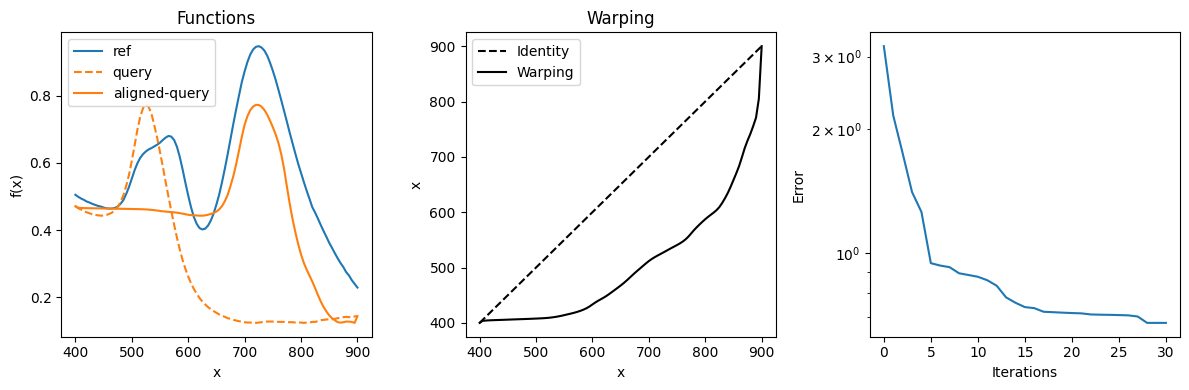

In [10]:
amplitude, phase, case2 = torch_apdist(torch.from_numpy(wav_scaled),
                                       torch.from_numpy(cylinder),
                                       torch.from_numpy(sphere),
                                       **optim_kwargs
                                    )
print("Amplitude : %2.4f, Phase : %2.4f, Total : %2.4f"%(amplitude.item(), phase.item(), (amplitude+phase).item()))
plot_warping_torch(wav, cylinder, sphere, case2)

As it turns out, the warping solution from gradient descent is much closer to the discrete approach. There are several reasons why we are unable to warp the sphere curve to have two peaks. One of the main reasons is that the set of warping functions we search for, only includes those that do not add any extra features but rather align the ones that they do have to match them best. 

In some sense, we are not treating these spectra as open curves in 2D that can be freely deformed but rather functions that can only be warped on the x-axis.